## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from catboost import CatBoostRegressor

In [2]:
data = pd.read_csv('../OnlineNewsPopularity/OnlineNewsPopularity.csv')
data.columns = [x.strip() for x in data.columns.tolist()]
X = data.drop(columns = ['url', 'timedelta', 'shares'])
y = data['shares']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

### Distribution of response
*By Nathan Jung*

The mean of shares is 3395.3801836343455. The standard deviation of shares is 11626.950748651712.


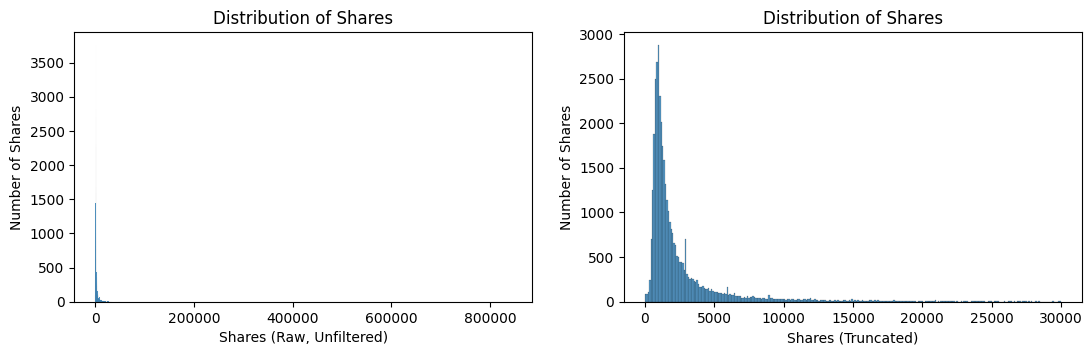

In [3]:
#...Plot for distribution of response...#
plt.rcParams["figure.figsize"] = [13.00, 3.50]
fig, axes = plt.subplots(1, 2)
num1 = sns.histplot(data.shares, ax = axes[0])
num2 = sns.histplot(data.shares[data.shares.apply(lambda x: False if x > 30000 else True)])
num1.set(xlabel = "Shares (Raw, Unfiltered)", title = "Distribution of Shares", ylabel = "Number of Shares")
num2.set(xlabel = "Shares (Truncated)", title = "Distribution of Shares", ylabel = "Number of Shares")
# Mean and standard deviation of response #
print("The mean of shares is {}. The standard deviation of shares is {}.".format(data.shares.mean(), data.shares.std()))

[Text(0.5, 0, 'Shares (logged)'),
 Text(0.5, 1.0, 'Distribution of logged Shares'),
 Text(0, 0.5, 'Number of Shares')]

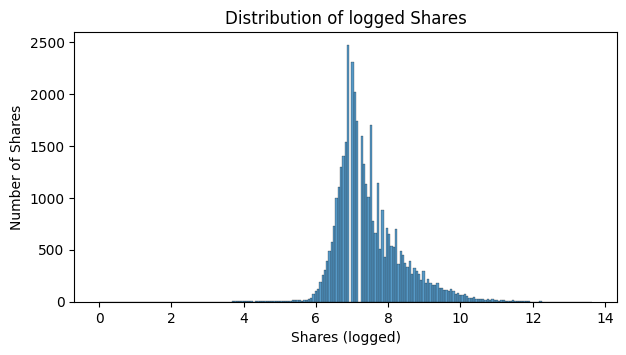

In [4]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
ax = sns.histplot(np.log(data.shares))
ax.set(xlabel = 'Shares (logged)', title = 'Distribution of logged Shares', ylabel = 'Number of Shares')

### Data cleaning
*By No One*

In [5]:
#...Code with comments...#
print("Missing values in X_train: {}, y_train: {}, X_test: {}, y_test: {}".format(X_train.isna().sum().sum(), y_train.isna().sum(), X_test.isna().sum().sum(), y_test.isna().sum()))
# There are no missing values

Missing values in X_train: 0, y_train: 0, X_test: 0, y_test: 0


### Data preparation
*By Nathan Jung*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. We removed variables with high multicollinearity.
2. We removed variables that were highly correlated with one another

In [6]:
# Judge based off of base_model_mae
base_model = LinearRegression().fit(X_train, np.log(y_train))
pred = base_model.predict(X_test)
# We are logging because, as seen before, there are extreme outliers in the data and logging will improve prediction accuracy
print(mean_absolute_error(y_test, np.exp(pred)))
base_model_mae = 2346.6317989298423

2346.631798929844


## Dropping Variables with High MultiCollinearity

In [7]:
total_dropped = 0
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# Systematically go through VIF chart, and remove the most highly correlated until no longer have high values of VIF.
to_drop = ['weekday_is_monday', 'weekday_is_saturday', 'LDA_00', 'n_unique_tokens', 'n_non_stop_words', 'self_reference_avg_sharess',
          'rate_positive_words']
# The variables right now result in the lowest MAE we can get, all other variable removals increase the MAE
X = add_constant(X_train.drop(columns = to_drop))
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)   

total_dropped += len(to_drop)
# Total variables dropped due to multicollinearity is 9
base_model = LinearRegression().fit(X_train.drop(columns = to_drop), np.log(y_train))
pred = np.exp(base_model.predict(X_test.drop(columns = to_drop)))
print('base mae = {}'.format(base_model_mae))
print('new_model mae = {}'.format(mean_absolute_error(y_test, pred)))
print('diff mae = {}'.format(mean_absolute_error(y_test, pred) - base_model_mae))

base mae = 2346.6317989298423
new_model mae = 2345.4043454122047
diff mae = -1.2274535176375139


In [8]:
# Since better difference, remove the predictors entirely
X_train.drop(columns = to_drop, inplace = True)
X_test.drop(columns = to_drop, inplace = True)
all_dropped_predictors = to_drop

# Find new base_model_mae
base_model = LinearRegression().fit(X_train, np.log(y_train))
pred = base_model.predict(X_test)
# We are logging because, as seen before, there are extreme outliers in the data and logging will improve prediction accuracy
print(mean_absolute_error(y_test, np.exp(pred)))
base_model_mae = 2345.404345416382

2345.4043454122047


## Dropping variables that are highly correlated with each other

In [9]:
# Now for the key part, removing variables with high level of correlation with one another
# Using coarse grid for correlation to reject between variables
correlation_range = [(x / 10) for x in range(0, 11, 1)]
maes = pd.DataFrame()

iteration = 0
for correlation in correlation_range:
    actual_columns_drop = []
    columns_to_drop = []
    X_train_copy = X_train.copy()
    while (True):
        try:
            # Systematically remove variables one by one from dataset copy based on correlation, and break when no more variables to remove
            correlations = X_train_copy.corr(numeric_only = True)
            first_column = correlations.iloc[0].name
            index = correlations[first_column].apply(lambda x: False if x == 1 else True if (np.abs(x) > correlation) else False)
            to_drop = correlations[first_column].loc[index].index.tolist()
            columns_to_drop.append(to_drop)
            X_train_copy = X_train_copy.drop(columns = to_drop).drop(columns = first_column)
        except:
            break
            
    # Make column list of lists of columns into one list of columns
    for columns in columns_to_drop:
        for column in columns:
            actual_columns_drop.append(column)
            
    # Create new model based off of new columns to drop, and then add the mae to maes
    model = LinearRegression().fit(X_train.drop(columns = actual_columns_drop), np.log(y_train))
    pred = model.predict(X_test.drop(columns = actual_columns_drop))
    model_mae = mean_absolute_error(y_test, np.exp(pred))
    
    maes.loc[iteration, 'MAE'] = model_mae
    maes.loc[iteration, 'correlation'] = correlation
    maes.loc[iteration, 'diff_MAE'] = model_mae - base_model_mae
    maes.loc[iteration, 'model'] = model
    maes.loc[iteration, 'total_dropped'] = len(actual_columns_drop)
    iteration += 1

In [10]:
# Based off of the MAES I'm seeing in the dataframe below, we can see that the MAE generally doesn't rise all that much
# As the correlation decreases. The differences in the MAE show, however, that the correlation we should investigate is 
# somewhere within the range of 0.3 - 1.0. (Negative difference = Better Model)
maes

,MAE,correlation,diff_MAE,model,total_dropped
0,2376.217700,0.0,3.081335e+01,LinearRegression(),50.0
1,2366.838762,0.1,2.143442e+01,LinearRegression(),40.0
2,2359.546681,0.2,1.414234e+01,LinearRegression(),34.0
3,2330.523312,0.3,-1.488103e+01,LinearRegression(),24.0
4,2324.640043,0.4,-2.076430e+01,LinearRegression(),21.0
5,2328.696946,0.5,-1.670740e+01,LinearRegression(),15.0
6,2318.411931,0.6,-2.699241e+01,LinearRegression(),10.0
7,2318.400205,0.7,-2.700414e+01,LinearRegression(),10.0
8,2317.661764,0.8,-2.774258e+01,LinearRegression(),4.0
9,2366.003096,0.9,2.059875e+01,LinearRegression(),1.0


In [11]:
# Finer correlation search
correlation_range = [(x / 100) for x in range(30, 90, 5)]
maes = pd.DataFrame()

iteration = 0
for correlation in correlation_range:
    actual_columns_drop = []
    columns_to_drop = []
    X_train_copy = X_train.copy()
    while (True):
        try:
            # Systematically remove variables one by one from dataset copy based on correlation, and break when no more variables to remove
            correlations = X_train_copy.corr(numeric_only = True)
            first_column = correlations.iloc[0].name
            index = correlations[first_column].apply(lambda x: False if x == 1 else True if (np.abs(x) > correlation) else False)
            to_drop = correlations[first_column].loc[index].index.tolist()
            columns_to_drop.append(to_drop)
            X_train_copy = X_train_copy.drop(columns = to_drop).drop(columns = first_column)
        except:
            break
            
    # Make column list of lists of columns into one list of columns
    for columns in columns_to_drop:
        for column in columns:
            actual_columns_drop.append(column)
            
    # Create new model based off of new columns to drop, and then add the rmse to rmses
    model = LinearRegression().fit(X_train.drop(columns = actual_columns_drop), np.log(y_train))
    pred = model.predict(X_test.drop(columns = actual_columns_drop))
    model_mae = mean_absolute_error(y_test, np.exp(pred))
    
    maes.loc[iteration, 'MAE'] = model_mae
    maes.loc[iteration, 'correlation'] = correlation
    maes.loc[iteration, 'diff_MAE'] = model_mae - base_model_mae
    maes.loc[iteration, 'model'] = model
    maes.loc[iteration, 'total_dropped'] = len(actual_columns_drop)
    iteration += 1

In [12]:
# When looking at the difference in MAE, we can see that the correlation to aim for when removing predictors is either
# 0.35 - 0.5 or 0.60-0.8. However, we will choose to go with 0.60 - 0.80, because that results in the best reduction in MAE
maes

# Therefore we will do one more final fine search in the correlation from 0.6 - 0.8 in order as that results in the greatest
# reduction in MAE

,MAE,correlation,diff_MAE,model,total_dropped
0,2330.523312,0.30,-14.881033,LinearRegression(),24.0
1,2329.399771,0.35,-16.004574,LinearRegression(),22.0
2,2324.640043,0.40,-20.764303,LinearRegression(),21.0
3,2321.507984,0.45,-23.896362,LinearRegression(),20.0
4,2328.696946,0.50,-16.707399,LinearRegression(),15.0
5,2328.333511,0.55,-17.070835,LinearRegression(),14.0
6,2318.411931,0.60,-26.992415,LinearRegression(),10.0
7,2318.400205,0.65,-27.004140,LinearRegression(),10.0
8,2318.400205,0.70,-27.004140,LinearRegression(),10.0
9,2317.604593,0.75,-27.799752,LinearRegression(),6.0


In [13]:
# Finest correlation search
correlation_range = [(x / 100) for x in range(60, 83, 1)]
maes = pd.DataFrame()

new_columns = []
iteration = 0
for correlation in correlation_range:
    actual_columns_drop = []
    columns_to_drop = []
    X_train_copy = X_train.copy()
    while (True):
        try:
            # Systematically remove variables one by one from dataset copy based on correlation, and break when no more variables to remove
            correlations = X_train_copy.corr(numeric_only = True)
            first_column = correlations.iloc[0].name
            index = correlations[first_column].apply(lambda x: False if x == 1 else True if (np.abs(x) > correlation) else False)
            to_drop = correlations[first_column].loc[index].index.tolist()
            columns_to_drop.append(to_drop)
            X_train_copy = X_train_copy.drop(columns = to_drop).drop(columns = first_column)
        except:
            break
            
    # Make column list of lists of columns into one list of columns
    for columns in columns_to_drop:
        for column in columns:
            actual_columns_drop.append(column)
            
    # Create new model based off of new columns to drop, and then add the rmse to rmses
    model = LinearRegression().fit(X_train.drop(columns = actual_columns_drop), np.log(y_train))
    pred = model.predict(X_test.drop(columns = actual_columns_drop))
    model_mae = mean_absolute_error(y_test, np.exp(pred))
    
    maes.loc[iteration, 'MAE'] = model_mae
    maes.loc[iteration, 'correlation'] = correlation
    maes.loc[iteration, 'diff_MAE'] = model_mae - base_model_mae
    maes.loc[iteration, 'model'] = model
    maes.loc[iteration, 'total_dropped'] = len(actual_columns_drop)
    new_columns.append(actual_columns_drop)
    iteration += 1

In [14]:
# We can find that the best correlation to choose to remove variables is 0.72, 0.73, or 0.74, but since it doesn't really matter
# We'll just go with 0.73
maes

,MAE,correlation,diff_MAE,model,total_dropped
0,2318.411931,0.60,-26.992415,LinearRegression(),10.0
1,2318.411931,0.61,-26.992415,LinearRegression(),10.0
2,2318.411931,0.62,-26.992415,LinearRegression(),10.0
3,2318.400205,0.63,-27.004140,LinearRegression(),10.0
4,2318.400205,0.64,-27.004140,LinearRegression(),10.0
5,2318.400205,0.65,-27.004140,LinearRegression(),10.0
6,2318.400205,0.66,-27.004140,LinearRegression(),10.0
7,2318.400205,0.67,-27.004140,LinearRegression(),10.0
8,2318.400205,0.68,-27.004140,LinearRegression(),10.0
9,2318.400205,0.69,-27.004140,LinearRegression(),10.0


In [15]:
# Final dataset is this one
X_train.drop(columns = new_columns[13], inplace = True)
X_test.drop(columns = new_columns[13], inplace = True)

In [16]:
# We have effectively cut the total predictors by 14 predictors
len(X_train.columns.tolist())

44

In [17]:
for x in new_columns[13]:
    all_dropped_predictors.append(x)
all_dropped_predictors
len(all_dropped_predictors)

14

## Exploratory data analysis

No EDA done

## Developing the model: Hyperparameter tuning

Use our github repository and the specific file names to find the hyperparameter tuning files.<br>
[This link here](https://github.com/Abenezer2/303_3-Final-Project)

### MARS, CatBoost
*Abenezer Bekele*

[MARS_CatBoost_Tuning.ipynb](https://github.com/Abenezer2/303_3-Final-Project/blob/main/MARS_CatBoost_Tuning.ipynb)

### Random Forest
*By Jack O'Keefe*

[RandomForest_Tuning.ipynb](https://github.com/Abenezer2/303_3-Final-Project/blob/main/RandomForest_Tuning.ipynb) 

### XGBoost
*By Nathan Jung*

[XGBoost_Model_Colab.ipynb](https://github.com/Abenezer2/303_3-Final-Project/blob/main/XGBoost_Model_colab.ipynb)

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


In [18]:
# Random Forest Model
random_forest_model = RandomForestRegressor(max_depth = 20, bootstrap = True, max_features = 10, n_estimators = 400, 
                                            oob_score = True)
random_forest_model = TransformedTargetRegressor(random_forest_model, func = np.log, 
                                                 inverse_func = np.exp).fit(X_train, y_train)
print("Random Forest Model MAE: {}".format(mean_absolute_error(y_test, random_forest_model.predict(X_test))))

# XGBoost model
xgb_model = xgb.XGBRegressor(random_state = 1, max_depth = 4, learning_rate = 0.01,
                        n_estimators = 1000,reg_lambda = 0, reg_alpha = 5, gamma = 6, subsample = 0.6, 
                         colsample_bytree = 0.75, eval_metric = mean_absolute_error)
xgb_model = TransformedTargetRegressor(xgb_model, func = np.log, inverse_func = np.exp)

xgb_model.fit(X_train, y_train)
print("XGBoost Model MAE: {}".format(mean_absolute_error(y_test, xgb_model.predict(X_test))))

# MARS model
mars_model = Earth(max_terms = 300, max_degree = 1)
mars_model = TransformedTargetRegressor(mars_model, func = np.log, inverse_func = np.exp).fit(X_train, y_train)
print("MARS Model MAE: {}".format(mean_absolute_error(y_test, mars_model.predict(X_test))))

# CatBoost model
cat_model = CatBoostRegressor(subsample=0.75, reg_lambda=10, depth=6, n_estimators=1000, learning_rate=0.01,random_state=1, verbose=False)
cat_model= TransformedTargetRegressor(cat_model, func = np.log, inverse_func = np.exp).fit(X_train, y_train)
print("CatBoost Model MAE: {}".format(mean_absolute_error(y_test, cat_model.predict(X_test))))

Random Forest Model MAE: 2269.3847340487255
XGBoost Model MAE: 2259.82102337598


C:\Users\nhj4\anaconda3\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
C:\Users\nhj4\anaconda3\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


MARS Model MAE: 2290.4558841026337
CatBoost Model MAE: 2263.3215481002567


### Voting ensemble

In [19]:
# Abenezer / Nathan
en=VotingRegressor(estimators = [('xgb',xgb_model),('random_forest',random_forest_model),('mars',mars_model), ("cat", cat_model)])
en.fit(X_train,y_train)
print("Voting Ensemble model MAE = ", mean_absolute_error(en.predict(X_test),y_test))

C:\Users\nhj4\anaconda3\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
C:\Users\nhj4\anaconda3\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Voting Ensemble model MAE =  2264.093336921037


### Stacking ensemble(s)

In [20]:
# Abenezer
en3 = StackingRegressor(estimators = [('xgb', xgb_model),('random_forest', random_forest_model),('mars', mars_model),('cat',cat_model)],
                     final_estimator=LassoCV(),                                          
                    cv = KFold(n_splits = 5, shuffle = True, random_state=1))
en3.fit(X_train,y_train)
print("Stacking Ensemble model MAE = ", mean_absolute_error(en3.predict(X_test), y_test))

C:\Users\nhj4\anaconda3\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
C:\Users\nhj4\anaconda3\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
C:\Users\nhj4\anaconda3\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the fut

Stacking Ensemble model MAE =  2851.1253341109673


### Ensemble of ensembled models

In [21]:
# Nathan
en=VotingRegressor(estimators = [('voting', en), ("stacking", en3)])
en.fit(X_train,y_train)
print("Ensembled Ensemble model MAE = ", mean_absolute_error(en.predict(X_test),y_test))

C:\Users\nhj4\anaconda3\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
C:\Users\nhj4\anaconda3\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
C:\Users\nhj4\anaconda3\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the fut

Ensembled Ensemble model MAE =  2471.997577553406
